In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
parsedXML = ET.parse( "corpus.xml" )
root = parsedXML.getroot()

In [ ]:
# for storing and manipulating data
import pandas as pd
# for tokenization and selecting only valid words
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:

def clean_body(email_tag, sender):

    sender_list = sender.split()

    sender_list[-1] = sender_list[-1].replace('>', '').replace('<', '')

    email_stoppers = [l for l in sender_list if len(l) > 2] + ['regards'
            , 'thanks', 'cheers']

    clean_email = ''

    for email_item in email_tag:

        sent = nlp(email_item.text)

        clean_sent = ' '.join([token.text.lower() for token in sent
                              if token.is_alpha and not token.is_punct])

        if sum([1 for word in email_stoppers if word in clean_sent
               and len(clean_sent.split()) <= 10]) >= 1:
            break

        clean_email += clean_sent + ' '

    return clean_email


In [ ]:


def parse_bc3_emails(root):
    '''
    This adds every BC3 email to a newly created dataframe. 
    '''

    BC3_email_list = []

    # The emails are seperated by threads.

    for thread in root:
        email_num = 0

        # Iterate through the thread elements <name, listno, Doc>

        for thread_element in thread:

            # Getting the listno allows us to link the summaries to the correct emails

            if thread_element.tag == 'listno':
                listno = thread_element.text

            # Each Doc element is a single email

            if thread_element.tag == 'DOC':
                email_num += 1
                email_metadata = []
                sender = thread_element.find('.//From').text.lower()
                subject = thread_element.find('.//Subject').text.lower()
                email_tag = thread_element.find('.//Text')
                subject_doc = nlp(subject)
                subject = ' '.join([token.text.lower() for token in
                                   subject_doc if token.is_alpha
                                   and not token.is_punct])
                cleaned_body = clean_body(email_tag, sender)
                email_dict = {
                    'listno': listno,
                    'from': sender.split()[0],
                    'subject': subject,
                    'body': cleaned_body,
                    'email_num': email_num,
                    }

                BC3_email_list.append(email_dict)
    return pd.DataFrame(BC3_email_list)


In [ ]:
bc3_email_df = parse_bc3_emails(root)
bc3_email_df.head(2)


,listno,from,subject,body,email_num
0,007-7484738,jacob,extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,1
1,007-7484738,terry,re extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,2


In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


def parse_bc3_summaries(root):
    '''
    This parses every BC3 Human summary that is contained in the dataset. 
    '''

    BC3_summary_list = []
    for thread in root:

        # Iterate through the thread elements <listno, name, annotation>

        for thread_element in thread:
            if thread_element.tag == 'listno':
                listno = thread_element.text

            # Each Doc element is a single email

            if thread_element.tag == 'annotation':
                for annotation in thread_element:

                # If the email_attri is summary, then each child contains a summarization line

                    if annotation.tag == 'summary':
                        summary_dict = {}
                        for summary in annotation:

                            # Generate the set of emails the summary sentence belongs to (often a single email)

                            email_nums = summary.attrib['link'
                                    ].split(',')
                            s = set()
                            for num in email_nums:
                                s.add(num.split('.')[0].strip())

                            # Remove empty strings, since they summarize whole threads instead of emails.

                            s = [x for x in set(s) if x]
                            for email_num in s:
                                if email_num in summary_dict:
                                    summary_dict[email_num] += ' ' \
    + summary.text
                                else:
                                    summary_dict[email_num] = \
    summary.text
                    elif annotation.tag == 'desc':

                    # get annotator description

                        annotator = annotation.text

                # For each email summarizaiton create an entry

                for (email_num, summary) in summary_dict.items():
                    summary_doc = nlp(summary)
                    summary = ' '.join([token.text.lower() for token in
                            summary_doc if token.is_alpha
                            and not token.is_punct])
                    email_dict = {
                        'listno': listno,
                        'annotator': annotator,
                        'email_num': email_num,
                        'summary': summary,
                        }
                    BC3_summary_list.append(email_dict)
    return pd.DataFrame(BC3_summary_list)


In [ ]:
#Load summaries and process
parsedXML = ET.parse( "annotation.xml" )
root = parsedXML.getroot()

bc3_summary_df = parse_bc3_summaries(root)
bc3_summary_df['email_num'] = bc3_summary_df['email_num'].astype(int)

#merge the dataframes together
bc3_df = pd.merge(bc3_email_df, 
                  bc3_summary_df[['annotator', 'email_num', 'listno', 'summary']],
                 on=['email_num', 'listno'])
bc3_df.head(2)

,listno,from,subject,body,email_num,annotator,summary
0,007-7484738,jacob,extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,1,Annotator3-Part2,jacob suggested to hold two week meetings the ...
1,007-7484738,jacob,extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,1,Annotator2-Part2,jacob suggests that future ietf meetings be sp...


In [ ]:
emails_df=bc3_df.groupby(['listno','email_num']).first()
emails_df['listno'] = emails_df.index.get_level_values(0)
emails_df['email_num'] = emails_df.index.get_level_values(1)
emails_df=emails_df.reset_index(drop=True)
emails_df.head()

,from,subject,body,annotator,summary,listno,email_num
0,jacob,extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,Annotator3-Part2,jacob suggested to hold two week meetings the ...,007-7484738,1
1,terry,re extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,Annotator3-Part2,terry supported jacob idea and suggested a fir...,007-7484738,2
2,brian,re extending ietf meetings to two weeks,terry wg chairs already are asked to specify w...,Annotator3-Part2,brian was against spreading the meetings thinner,007-7484738,3
3,larry,create final ietf agenda schedule earlier,working groups do seem to decide at the last m...,Annotator3-Part2,larry commented that they could create the iet...,007-7484738,4
4,richard,re create final ietf agenda schedule earlier,for example it would be very useful so that th...,Annotator3-Part2,richard supported larry and said it will help ...,007-7484738,5


In [ ]:
  emails_df['email'] = emails_df['from'] + ' said ' + emails_df['body']
  emails_df.head(2)

,from,subject,body,annotator,summary,listno,email_num,email
0,jacob,extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,Annotator3-Part2,jacob suggested to hold two week meetings the ...,007-7484738,1,jacob said the ietf meetings tend to become to...
1,terry,re extending ietf meetings to two weeks,the ietf meetings tend to become too large cre...,Annotator3-Part2,terry supported jacob idea and suggested a fir...,007-7484738,2,terry said the ietf meetings tend to become to...


In [ ]:
emails_df = emails_df[['listno','email_num','email','summary']]

In [ ]:
emails_df = emails_df.set_index('listno')
threads_df = pd.DataFrame(index=emails_df.index.unique())
threads_df['thread'] = emails_df.groupby('listno')['email'].transform(lambda x : ' '.join(x)).drop_duplicates()
threads_df['summary'] = emails_df.groupby('listno')['summary'].transform(lambda x : ' '.join(x)).drop_duplicates()
threads_df = threads_df.reset_index()
threads_df.head(2)

,listno,thread,summary
0,007-7484738,jacob said the ietf meetings tend to become to...,jacob suggested to hold two week meetings the ...
1,015-2625401,libby said hi all as outlined at the face to f...,libby wrote to the list asking for data she as...


In [ ]:
len(threads_df)

39

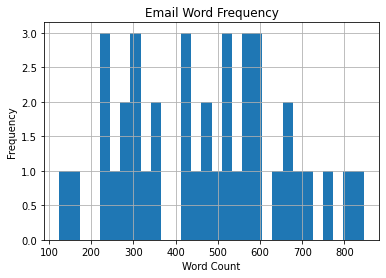

In [ ]:
import matplotlib.pyplot as plt
email_word_count = pd.Series([len(i.split()) for i in threads_df.thread])
email_word_count.hist(bins = 30)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Email Word Frequency')
plt.show()

In [ ]:
from statistics import mean, median
print('Max words: ',max(email_word_count))
print('Avg words: ',mean(email_word_count))
print('Median words: ',median(email_word_count))


Max words:  846
Avg words:  468.87179487179486
Median words:  474


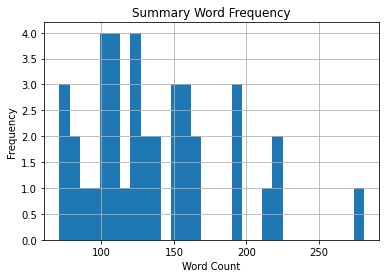

In [ ]:
summary_word_count = pd.Series([len(i.split()) for i in threads_df.summary])
summary_word_count.hist(bins = 30)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Summary Word Frequency')
plt.show()

In [ ]:
print('Max words: ',max(summary_word_count))
print('Avg words: ',mean(summary_word_count))
print('Meddian words: ',median(summary_word_count))


Max words:  281
Avg words:  136.23076923076923
Meddian words:  123


In [ ]:
words_in_thread = 450
words_in_summary = 130

In [ ]:
import numpy as np
import torch


In [ ]:
!pip install pytorch_lightning
!pip install rouge_score
!pip install -U nlp
!pip install rouge 

import pytorch_lightning as pl
import torch
from nlp import load_metric
import numpy as np
import time



Requirement already up-to-date: nlp in /usr/local/lib/python3.7/dist-packages (0.4.0)


In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
      super(T5FineTuner, self).__init__()
      self.save_hyperparameters()
      self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
      self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
      self.rouge_metric = load_metric('rouge') 
    
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))

    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None
      , labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
    )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=20, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=0.001, eps=0.00000001)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
        optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):
      train_dataset = get_dataset(self.tokenizer,"train")
      dataloader = DataLoader(train_dataset, batch_size=1, drop_last=True, shuffle=True, num_workers=4)
      t_total = (
          (len(dataloader.dataset) // (1 * max(1,1)))
          // 1
          * float(10)
      )
      scheduler = get_linear_schedule_with_warmup(
          self.opt, num_warmup_steps=0, num_training_steps=t_total
      )
      self.lr_scheduler = scheduler
      return dataloader

    def val_dataloader(self):
      val_dataset = get_dataset(self.tokenizer,"val")
      return DataLoader(val_dataset, batch_size=1, num_workers=4)

In [ ]:
from torch.utils.data import Dataset, DataLoader


In [ ]:
class EmailThreadDataset(Dataset):
  def __init__(self, tokenizer, type_path, data_col,target_col, words_in_thread, words_in_summary):
    self.data_column = data_col
    self.class_column = target_col

    self.data = threads_df
    if type_path == 'train':
      self.data = threads_df.iloc[:32][['thread','summary']]
    elif type_path == 'val':
      self.data = threads_df.iloc[32:36][['thread','summary']]
    elif type_path == 'test':
      self.data = threads_df.iloc[36:40][['thread','summary']]

    self.words_in_thread = words_in_thread
    self.words_in_summary = words_in_summary
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  '''
  Tokenize Email and Summary along with their attention mask.
  The attention mask is an optional argument used when batching sequences together. 
  This argument indicates to the model which tokens should be attended to, and which should not.
  '''  
  def _build(self):
    for index, row in self.data.iterrows():
      input_, target = row[self.data_column], row[self.class_column]

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.words_in_thread, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=self.words_in_summary, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
!pip install sentencepiece==0.1.90
!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.9.0.dev0-cp37-none-any.whl size=2534203 sha256=894a9eb935438129e1fff7666535a383ee15b3914129e5e891fe0b218fa89d3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-df0v8ch0/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 4.9.0.dev0
    Uninstalling transformers-4.9.0.dev0:
      Successfully uninstalled transformers-4.9.0.dev0


In [ ]:
'''
T5-Small (60 million parameters): gs://t5-data/pretrained_models/small
T5-Base (220 million parameters): gs://t5-data/pretrained_models/base
T5-Large (770 million parameters): gs://t5-data/pretrained_models/large
T5-3B (3 billion parameters): gs://t5-data/pretrained_models/3B
T5-11B (11 billion parameters): gs://t5-data/pretrained_models/11B
'''

tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = EmailThreadDataset(tokenizer,'val','thread','summary',  words_in_thread, words_in_summary)
len(dataset)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


4

In [ ]:

args_dict = dict(
    output_dir="./Email Thread Summarization/Model/T5", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    data_col='thread',
    target_col='summary',
    words_in_thread=words_in_thread, 
    words_in_summary=words_in_summary,
    max_seq_length=400,
    learning_rate=3e-4,
    freeze_encoder=False,
    freeze_embeds=False,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=10,
    gradient_accumulation_steps=1,
    n_gpu=1,
    # early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
import argparse

args = argparse.Namespace(**args_dict)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir,
    filename= 'best-checkpoint',
    save_top_k=1,
    monitor="val_loss", 
    mode="min",
    verbose =True)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
)

In [ ]:
def get_dataset(tokenizer, type_path):
  return EmailThreadDataset(tokenizer, type_path, 'thread', 'summary', words_in_thread, words_in_summary)

In [ ]:
model = T5FineTuner(argparse.Namespace(**args_dict))

In [ ]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoa

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = EmailThreadDataset(tokenizer,  'test','thread','summary',  words_in_thread, words_in_summary)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def get_summary(batch, i):
    original_thread = ''
    actual_summary = ''
    predicted_summary = '' 

    batch["source_ids"].shape
    model.to('cuda')

    outs = model.model.generate(
                batch["source_ids"].cuda(),
                attention_mask=batch["source_mask"].cuda(),
                use_cache=True,
                decoder_attention_mask=batch['target_mask'].cuda(),
                max_length=200, 
                num_beams=2,
                repetition_penalty=2.1, 
                length_penalty=1.0, 
                early_stopping=True
            )
    dec = [tokenizer.decode(ids) for ids in outs]

    texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
    targets = [tokenizer.decode(ids) for ids in batch['target_ids']]
    original_thread += texts[0].replace('<pad>','').replace('</s>','').strip()+'. \n'

    actual_summary += targets[0].replace('<pad>','').replace('</s>','').strip()+'. \n'

    predicted_summary += dec[0].replace('<pad>','').replace('</s>','').strip()+'. \n'
    predicted_summary = re.sub('(<extra_id_(\d)+)>','',predicted_summary)

    lines = textwrap.wrap(original_thread,width=100)
    print('\nOrigianl thread No. '+str(i+1)+': \n\n','\n'.join(lines))

    lines = textwrap.wrap(actual_summary,width=300)
    print('\nActual Summary No. '+str(i+1)+': \n\n','\n'.join(lines))

    lines = textwrap.wrap(predicted_summary,width=300)
    print('\nPredicted Summary No.  '+str(i+1),': \n\n','\n'.join(lines))

    scores = evaluator.get_scores(predicted_summary, original_thread)
    print()
    print("ROUGE-1: ",scores[0]["rouge-1"],  "\n")
    print("ROUGE-2: ",scores[0]["rouge-2"],  "\n")
    print("ROUGE-l: ",scores[0]["rouge-l"],  "\n")


In [ ]:
import textwrap
import rouge
evaluator = rouge.Rouge()

loader = DataLoader(dataset, batch_size=1)
it = iter(loader)
for i in range(len(dataset.data)):
  batch = next(it)
  get_summary(batch,i)




Origianl thread No. 1: 

 paul said blankit a appears another interesting case goes to court today where a wheel chair user is
seeking compensation from london stanstead airport and ryan air for charging for the use of a
wheelchair and lift to get onto the plane i realise it is the airlines that take the flak for this
but i believe it is the airport authority that makes the charge i think he has an open and shut case
but the outcome will be interesting and i believe the airline and airport are only contesting the
case as this sets a precedent to supply a reasonable service for all disabled travellers world wide
shame on them jon@hackcraft.net said blankit a appears another interesting case goes to court today
where a wheel chair user is seeking compensation from london stanstead airport and ryan air for
charging for the use of a wheelchair and lift to get onto the plane when i worked for a tourism dot
com some years ago we were shy about suggesting that customers sue over this it was 

In [ ]:
input_ids = tokenizer('''Summarization: terry suggested to Asma if we can improve our model performance. 
Asma replied that before improving the model we need to clean our data properly referring to data 
centric approach''',return_tensors='pt').input_ids
generated_ids =  model.model.generate(input_ids.cuda())
preds = [tokenizer.decode(gen_id,skip_special_tokens=True, clean_up_tokenization_spaces=True)  for gen_id in generated_ids]
print('Summary: ',"".join(preds))

Summary:  : terry suggested to Asma if we can improve our model performance.


In [ ]:
input_ids = tokenizer('''Summarization: I need urgent response on our last meeting and want W3C memebers to take this very serious.''',return_tensors='pt').input_ids
generated_ids =  model.model.generate(input_ids.cuda())
preds = [tokenizer.decode(gen_id,skip_special_tokens=True, clean_up_tokenization_spaces=True)  for gen_id in generated_ids]
print('Summary: ',"".join(preds))

Summary:  ''I need urgent response on my last meeting''


In [ ]:
input_ids = tokenizer('''Summarization: As discussed we are expecting to have update data extract from areeb with additional filters 
and contain all accounts details of branch customer. We have concluded way forward in today meeting with you. 
we are looking to have definitions and update data set, once we have it we are ready for execution of data loading process 
into ant aml data stores. ''',return_tensors='pt').input_ids
generated_ids =  model.model.generate(input_ids.cuda())
preds = [tokenizer.decode(gen_id,skip_special_tokens=True, clean_up_tokenization_spaces=True)  for gen_id in generated_ids]
print('Summary: ',"".join(preds))

Summary:  : ANT aml We are expecting to have definitions and update data set
